## Python 中用于特征选择的递归特征消除 (RFE)

递归特征消除
递归特征消除，简称RFE，是一种特征选择算法。

用于分类或回归的机器学习数据集由行和列组成，例如 Excel 电子表格。行通常被称为样本，列被称为特征，例如问题域中的观察特征。

特征选择是指为数据集选择最相关特征（列）的子集的技术。更少的功能可以让机器学习算法更有效地运行（更少的空间或时间复杂度）并且更有效。一些机器学习算法可能会被不相关的输入特征误导，导致预测性能变差。

有关一般特征选择的更多信息，请参阅教程：

Python中机器学习的特征选择
RFE 是一种包装类型的特征选择算法。这意味着在方法的核心中给出并使用了不同的机器学习算法，由 RFE 包装，用于帮助选择特征。这与基于过滤器的特征选择形成对比，后者对每个特征进行评分并选择那些得分最高（或最小）的特征。

从技术上讲，RFE 是一种包装风格的特征选择算法，它在内部也使用基于过滤器的特征选择。

RFE 的工作原理是从训练数据集中的所有特征开始搜索特征子集，然后成功删除特征，直到保留所需的数量。

这是通过拟合模型核心中使用的给定机器学习算法、按重要性对特征进行排序、丢弃最不重要的特征并重新拟合模型来实现的。重复此过程，直到保留指定数量的特征。

In [5]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.885 (0.036)


In [6]:
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=5)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -27.555 (2.786)


RFE 超参数

在本节中，我们将仔细研究一些您应该考虑调整用于特征选择的 RFE 方法的超参数及其对模型性能的影响。

探索功能数量
RFE 算法的一个重要超参数是要选择的特征的数量。

在上一节中，我们使用了任意数量的选定特征，五个，它与合成数据集中的信息特征的数量相匹配。在实践中，我们无法知道使用 RFE 选择的最佳特征数量；相反，测试不同的值是一种很好的做法。

下面的示例演示了在合成二进制分类数据集上选择从 2 到 10 的不同数量的特征。

>2 0.725 (0.040)
>3 0.820 (0.033)
>4 0.872 (0.033)
>5 0.888 (0.036)
>6 0.891 (0.029)
>7 0.888 (0.027)
>8 0.893 (0.030)
>9 0.882 (0.027)


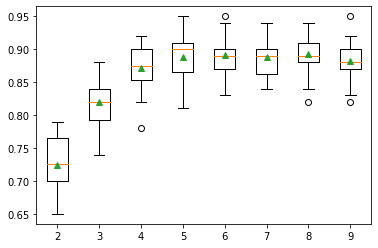

In [7]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

自动选择特征数量

也可以自动选择 RFE 选择的特征数量。

这可以通过对不同数量的特征进行交叉验证评估来实现，就像我们在上一节中所做的那样，并自动选择产生最佳平均分数的特征数量。

RFECV类为我们实现了这一点。

RFECV的配置与 RFE 类一样，关于所包装算法的选择。此外，可以通过“ min_features_to_select ”参数（默认为 1）指定要考虑的最小特征数量，我们还可以通过“ cv ”（默认为 5）指定要使用的交叉验证和评分的类型和“打分”参数（使用准确度进行分类）。

In [12]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
# rfe = RFECV(estimator=DecisionTreeClassifier())
rfe = RFECV(estimator=LogisticRegression())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.887 (0.030)


选择了哪些特征

使用 RFE 时，我们可能想知道哪些特征被选中，哪些特征被删除。

这可以通过查看拟合 RFE 对象（或拟合 RFECV 对象）的属性来实现。“ support_ ”属性报告包含按列索引顺序排列的特征的真假，“ ranking_ ”属性报告按相同顺序排列的特征的相对排名。

下面的示例在整个数据集上拟合一个 RFE 模型并选择五个特征，然后报告每个特征列索引（0 到 9）、是否被选择（True或False）以及相对特征排名。

In [10]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 3.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 6.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 2.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 4.000


探索基础算法

有许多算法可以在核心 RFE 中使用，只要它们提供一些变量重要性的指示。

大多数决策树算法可能会报告相同的特征重要性总体趋势，但这并不能保证。探索由 RFE 包装的不同算法的使用可能会有所帮助。

下面的示例演示了如何探索此配置选项。

>lr 0.891 (0.031)
>per 0.849 (0.038)
>cart 0.885 (0.031)
>rf 0.857 (0.035)
>gbm 0.888 (0.033)


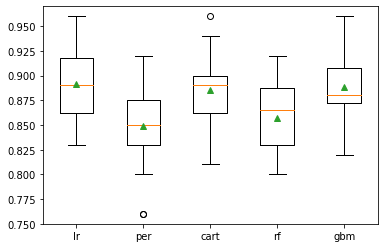

In [11]:
# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# perceptron
	rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

运行该示例首先报告每个包装算法的平均准确度。

注意：您的结果可能会因算法或评估程序的随机性或数值精度的差异而有所不同。考虑运行该示例几次并比较平均结果。

在这种情况下，结果表明像逻辑回归这样的线性算法可能比选择的决策树和决策树算法的集合更可靠地选择更好的特征。